## physics4481-7681/cs4812 ps5 problem 1

### due Fri 12 Nov 23:00 via gradescope

This is the first problem of ps5 -- the remaining problems are posted in [ps5.pdf](https://courses.cit.cornell.edu/physics4481-7681_2021fa/ps5.pdf).

---

In this problem, you will explore Grover's algorithm and implement it on a real quantum device. [This](https://qiskit.org/textbook/ch-algorithms/grover.html) page may be helpful.

### Question 1a:
What is the ideal probability of measuring the single marked state of $2^n$ possibilities, as a function of the number of Grover steps and the number of qubits $n$? 

Define the number of Grover steps to be t:
Ideal Probability: P(t)   ~  (sin((2*t+1)*arcsin(sqrt(1/N))))^2 where N = 2**n

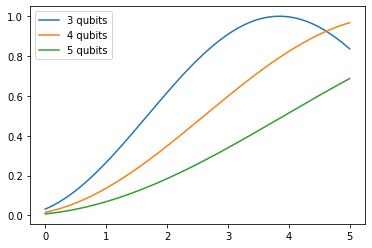

In [1]:
## Now create a plot of the success probability as a function of the number of grover steps.
## Go out to 5 grover steps and plot it for n = 3, 4, and 5 qubits, all on the same axis.

### Write your code here:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy


n = [3, 4, 5] #number of qubits
steps = np.linspace(0, 5, 10000) # go up to 5 grover steps

func3 = (np.sin((2*steps+1)*np.arcsin(np.sqrt(1/(2**n[0])))))**2
func4 = (np.sin((2*steps+1)*np.arcsin(np.sqrt(1/(2**n[1])))))**2
func5 = (np.sin((2*steps+1)*np.arcsin(np.sqrt(1/(2**n[2])))))**2

plt.plot(steps, func3, label = '3 qubits')
plt.plot(steps, func4, label = '4 qubits')
plt.plot(steps, func5, label = '5 qubits')
plt.legend()
###

### Question 1b:

Now let's see how well this works on a real quantum computer. Let's consider the case $n=3$. Generate a random integer between $0$ and $2^n - 1$ (inclusive). This will be our marked item.

In [2]:
n = 3
### write your code here. Make sure to print your marked number.
random_int = np.random.randint(low = 0, high = 2**n)
random_int 

1

Next, we will construct an oracle, called $U_f$ or $U_\omega$ in the [Qiskit textbook](https://qiskit.org/textbook/ch-algorithms/grover.html). You may use [this](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.diagonal.html) gate, which implements a diagonal unitary matrix.

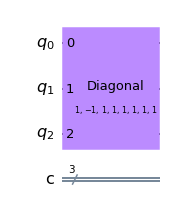

In [65]:
### complete the following code:
from qiskit import QuantumCircuit
dia = [1,1,1,1,1,1,1,1]
dia[random_int] = -1
Uf = QuantumCircuit(n,n) # we will use the classical registers later
Uf.diagonal(dia,list(range(n)))
Uf.draw()

Next, we need the diffuser $U_s$. Read the section "Creating a General Diffuser" in the [Qiskit textbook](https://qiskit.org/textbook/ch-algorithms/grover.html) and copy that function below.

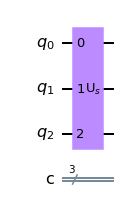

In [66]:
### copy the diffuser(nqubits) function from the Qiskit textbook here:
# Diffusion operator (U_s)
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

###

Us = QuantumCircuit(n,n)
Us.append(diffuser(n),range(n))
Us.draw()

We compose them to create a circuit for a Grover step:

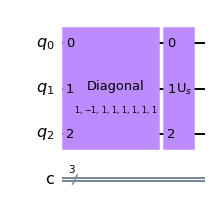

In [67]:
U_step = Uf.compose(Us)
U_step.draw()

### Question 1c:

Next, let's simulate Grover's algorithm for 1, 2, and 3 Grover steps and confirm that it agrees with our theoretical prediction.

In [68]:
circuits = [] # list of the circuits we will run
for n_steps in range(1,4):
    grover = QuantumCircuit(n,n) # our Grover search circuit
    grover.h(range(n))
    for _ in range(n_steps): grover = grover.compose(U_step) # repeat U_step n_steps times
    grover.measure(range(n),range(n))
    circuits.append(grover)
    

n=1 probability 0.781982421875
n=2 probability 0.94580078125
n=3 probability 0.3397216796875


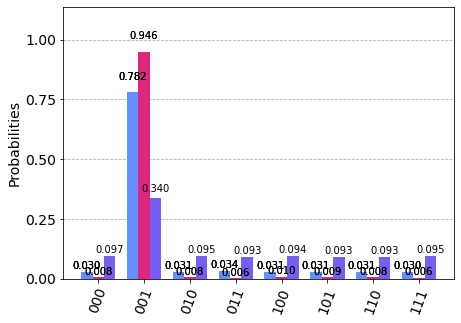

In [69]:
from qiskit import Aer, execute
simulator = Aer.get_backend('statevector_simulator')
job_sim = execute(circuits,simulator,shots=8192)

### fill in code below to extract the success rates from job_sim:
results = job_sim.result()
answers = results.get_counts()

print('n=1 probability', answers[0]['001']/sum(answers[0].values()))
print('n=2 probability', answers[1]['001']/sum(answers[1].values()))
print('n=3 probability', answers[2]['001']/sum(answers[2].values()))

plot_histogram(answers)

### Question 1d:

Now, let's run Grover's algorithm on a real quantum computer and see how well it performs. First, let's pick a device and transpile our circuit to the connectivity of that device. The transpiler is stochastic, so it does not give the same result each time. We will run it several times and pick the result with the fewest 2-qubit gates.

In [70]:
from qiskit import IBMQ
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-11-15 03:23:55,814: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [71]:
from qiskit.compiler import transpile

## uncomment one of the following two lines:
#provider = IBMQ.get_provider(hub='ibm-q-education', group='cornell-uni-2', project='physics-4481')
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.backend.ibmq_lima ## change this to the backend you want to use

In [72]:
# you may want to copy your code to construct U_step here if you find yourself running this cell multiple times:

U_step.measure(range(n),range(n)) # transpiling permutes the qubits, so it is helpful to add the measurement first. We will remove it from intermediate Grover steps
U_step_all = [transpile(U_step,backend,optimization_level=3) for _ in range(50)]
num_cx = [U.count_ops().get('cx',0) for U in U_step_all]
print(min(num_cx))
U_step_measure = U_step_all[num_cx.index(min(num_cx))]
U_step = U_step_measure.remove_final_measurements(inplace=False)


13


In [73]:
circuits = [] # list of the circuits we will run
for n_steps in range(1,4):
    grover = QuantumCircuit(U_step_measure.num_qubits,U_step_measure.num_clbits) # our Grover search circuit
    grover.h(range(n))
    for _ in range(n_steps): # add n_steps grover steps
        if _ != n_steps - 1:
            grover = grover.compose(U_step) 
        elif _ == n_steps - 1:
            grover = grover.compose(U_step_measure)
    circuits.append(grover)

In [74]:
# now run the circuits
from qiskit import execute
tags = ['Grover search','n = '+str(n),'marked number = '+str("marked_entry")] # set some descriptive tags
job = execute(circuits,backend,shots=8192,job_tags=tags) ## note: the number of shots is now 1024. Feel free to increase it if you need better statistics.

n=1 probability 0.6484375
n=2 probability 0.26123046875
n=3 probability 0.1280517578125


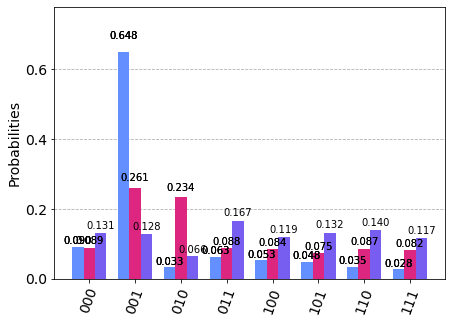

In [75]:
## print the success probability as a function of the number of Grover iterations.
results = job.result()
answers = results.get_counts()
print('n=1 probability', answers[0]['001']/sum(answers[0].values()))
print('n=2 probability', answers[1]['001']/sum(answers[1].values()))
print('n=3 probability', answers[2]['001']/sum(answers[2].values()))
plot_histogram(answers)


### How do your results compare to the theoretical prediction? Did Grover's algorithm succeed in increasing the probability of the marked state? Perform a hypothesis test to check whether the increase in the probability (compared to a uniform distribution) was statistically significant.

The theoritical prediction predicts (as plotted in 1a) that for qubit number n = 3, step = 2 gives the best ideal probability of finding the marked state (then step 2 and step 1). The Grover's algorithm running on a real quantum device agrees with the theoritical predcition in 1a) with step 3 gives the highest probability of success" 67.4%. Notice that the simulated results (job_sim) have n = 2 gives the highest probability of finding the state the optimal gorver step should be round(4 * pi * (sqrt(N/M))-1/2)

Text(0, 0.5, 'probability')

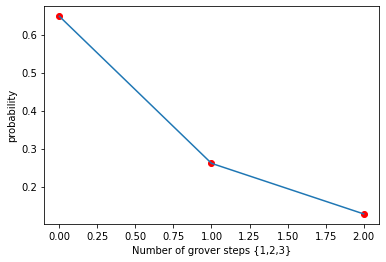

In [78]:
plt.plot(prob)
plt.scatter([0,1,2], prob, c ='r')
plt.xlabel('Number of grover steps {1,2,3}')
plt.ylabel("probability")

In [77]:
# hypothesis test - use anderson test
from scipy.stats import anderson

prob = [answers[0]['001']/sum(answers[0].values()), answers[1]['001']/sum(answers[1].values()), answers[2]['001']/sum(answers[2].values())]
result = anderson(prob)
print('Statistic: %.3f' % result.statistic)

p = 0
# H0: data comes from normal distribution
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0), the increase in probability is significant' % (sl, cv))

Statistic: 0.273
15.000: -1.296, data does not look normal (reject H0), the increase in probability is significant
10.000: -1.476, data does not look normal (reject H0), the increase in probability is significant
5.000: -1.771, data does not look normal (reject H0), the increase in probability is significant
2.500: -2.065, data does not look normal (reject H0), the increase in probability is significant
1.000: -2.457, data does not look normal (reject H0), the increase in probability is significant


### Question 1e:

Repeat parts b and d for $n=4$. Use 8192 shots this time to get good statistics. (Remember to generate a new random marked entry.) Comment on the results; write at least a full paragraph.

5


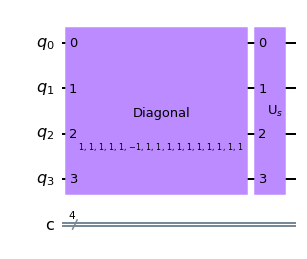

In [79]:
# repeat part b
n = 4
### generate a new marked entry 
random_int = np.random.randint(low = 0, high = 2**n)
print(random_int)

### complete the following code:
dia = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
dia[random_int] = -1

Uf = QuantumCircuit(n,n) # we will use the classical registers later
Uf.diagonal(dia, list(range(n)))
Uf.draw()


Us = QuantumCircuit(n,n)
Us.append(diffuser(n),range(n))
Us.draw()

U_step = Uf.compose(Us)
U_step.draw()


n=0 probability 0.4696044921875
n=1 probability 0.9093017578125
n=2 probability 0.958251953125


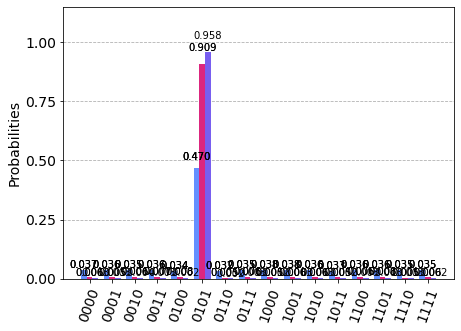

In [81]:
circuits = [] # list of the circuits we will run
for n_steps in range(1,4):
    grover = QuantumCircuit(n,n) # our Grover search circuit
    grover.h(range(n))
    for _ in range(n_steps): grover = grover.compose(U_step) # repeat U_step n_steps times
    grover.measure(range(n),range(n))
    circuits.append(grover)
    
from qiskit import Aer, execute
simulator = Aer.get_backend('statevector_simulator')
job_sim = execute(circuits,simulator,shots=8192)

### fill in code below to extract the success rates from job_sim:
results = job_sim.result()
answers = results.get_counts()


print('n=0 probability', answers[0]['0101']/sum(answers[0].values()))
print('n=1 probability', answers[1]['0101']/sum(answers[1].values()))
print('n=2 probability', answers[2]['0101']/sum(answers[2].values()))

plot_histogram(answers)

ibmqfactory.load_account:WARNING:2021-11-15 03:41:08,000: Credentials are already in use. The existing account in the session will be replaced.


44


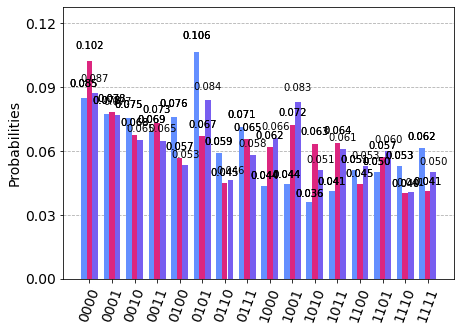

In [82]:
# repeat part d
from qiskit.compiler import transpile
from qiskit import IBMQ

n=4
IBMQ.load_account()
## uncomment one of the following two lines:
#provider = IBMQ.get_provider(hub='ibm-q-education', group='cornell-uni-2', project='physics-4481')
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.backend.ibmq_lima ## change this to the backend you want to use

U_step.measure(range(n),range(n)) # transpiling permutes the qubits, so it is helpful to add the measurement first. We will remove it from intermediate Grover steps
U_step_all = [transpile(U_step,backend,optimization_level=3) for _ in range(50)]
num_cx = [U.count_ops().get('cx',0) for U in U_step_all]
print(min(num_cx))
U_step_measure = U_step_all[num_cx.index(min(num_cx))]
U_step = U_step_measure.remove_final_measurements(inplace=False)

circuits = [] # list of the circuits we will run
for n_steps in range(1,4):
    grover = QuantumCircuit(U_step_measure.num_qubits,U_step_measure.num_clbits) # our Grover search circuit
    grover.h(range(n))
    for _ in range(n_steps): # add n_steps grover steps
        if _ != n_steps - 1:
            grover = grover.compose(U_step) 
        elif _ == n_steps - 1:
            grover = grover.compose(U_step_measure)
    circuits.append(grover)
    

# now run the circuits
from qiskit import execute
tags = ['Grover search','n = '+str(n),'marked number = '+str("marked_entry")] # set some descriptive tags
job = execute(circuits,backend,shots = 8192, job_tags=tags) ## note: the number of shots is now 1024. Feel free to increase it if you need better statistics.


## print the success probability as a function of the number of Grover iterations.
results = job.result()
answers = results.get_counts()
plot_histogram(answers)



In [83]:
# print statistics
print('n=1 probability', answers[0]['0101']/sum(answers[0].values()))
print('n=2 probability', answers[1]['0101']/sum(answers[1].values()))
print('n=3 probability', answers[2]['0101']/sum(answers[2].values()))

n=1 probability 0.1064453125
n=2 probability 0.06689453125
n=3 probability 0.0838623046875


###  Comments




As the number of grover steps increase, the probability of successfully finding the marked state increases, which agrees with the orange line shown in 1a (theoritical prediction).
Notice that for number of qubit n = 4, the increase in probability versus the increase in grover steps has smaller slope compared to the graph for qubit n = 3, which agrees with the theoritical prediction in 1a, and the formula for optimal grover step